In [2]:
import os
import csv
import pandas as pd
import time
import pickle
import sys

In [3]:
print(os.getcwd())
# cwd = os.chdir(os.path.join(os.getcwd(), "logda"))

/local-scratch/localhome/pagand/projects/DaTu/ML/logda


In [4]:
File_xlsx = "data/integration_log_group_a.xlsx"
File_csv = "data/group_a_raw.csv"
df = pd.read_excel(File_xlsx)
df = df.iloc[:, :-1] 

print(df.head())

  username           Date and Time Time since session started\n(h:mm:ss)  \
0       a1 2023-08-03 09:34:57.240                              00:00:00   
1       a1 2023-08-03 09:35:00.152                              00:00:02   
2       a1 2023-08-03 09:35:30.167                              00:00:32   
3       a1 2023-08-03 09:41:32.112                              00:06:34   
4       a1 2023-08-03 09:41:32.112                              00:06:34   

         space                     action  
0          NaN                 User login  
1   /courses/1                  Load page  
2  EDA Toolbox  Load default toolbox page  
3    Problem 1              Start problem  
4    Problem 1               First answer  


In [5]:
# get the unique values of the column action
unique_actions = df.action.unique()
# peint unique actions with their counts
print(df['action'].value_counts())

action
Change answer                      4363
First answer                       2159
Request another hint               1479
Streamlit interaction              1338
Update confidence                  1336
Auto-save log                      1018
New answer explanation              977
Load default toolbox page           942
Request first hint                  914
Paste answer                        646
Update answer explanation           597
Load page                           453
Freeform code run                   441
User request                        400
Chatbot response                    400
Run code                            314
Run code error                      276
Respond to hint feedback            166
Start reading sub-module            135
Start problem                       125
Submit problem                      111
User login                           53
Complete sub-module                  42
Save note                            22
Stop reading sub-module preview  

In [6]:
# since the frequency of different actions are different, Normalize the counts of actions by the total number of actions per user to account for the difference in frequencies.

# create new df where the rows are each user and the columns are the counts of each action from unique_actions
action_counts = pd.DataFrame(columns=unique_actions)
for user in df.username.unique():
    user_actions = df[df.username == user].action.value_counts()
    action_counts.loc[user, user_actions.index] = user_actions.values
action_counts = action_counts.fillna(0)
# add the total_actions column to the action_counts df
action_counts['total'] = df.groupby('username').count().action
flag = 0
action_counts.head()

,User login,Load page,Load default toolbox page,Start problem,First answer,New answer explanation,Update answer explanation,Update confidence,Request first hint,Request another hint,...,Freeform code run,Start reading sub-module,Complete sub-module,Run code error,User request,Chatbot response,Save note,Stop reading sub-module preview,User logout,total
a1,1,4,21,3,41,19,17,60,50,81,...,14,0,0,0,0,0,0,0,0,539
a2,1,22,12,1,11,11,6,11,13,26,...,0,11,5,3,0,0,0,0,0,202
a3,1,1,6,3,38,34,5,30,32,49,...,3,0,0,0,0,0,0,0,0,245
a4,1,37,42,3,76,9,11,16,36,69,...,0,6,1,11,6,6,4,0,0,679
a5,1,5,29,3,60,44,22,48,12,22,...,7,0,0,15,25,25,0,0,0,513


In [7]:
# read the scores
File_score_xlsx = "data/Groupa_scores.xlsx"
read_file = pd.read_excel(File_score_xlsx)

# change the first column name to username
read_file.rename(columns={"Participant ID's":'username', 'Problem 1 (Score out of 16)': 'score1',
                         'Problem 2 (Score out of 20)': 'score2', 'Problem 3 (Score out of 18)': 'score3' }, inplace=True)
read_file[:-3]
# use the username as the index
read_file.set_index('username', inplace=True)
# devide first column by 16, second column by 20, third column by 18
read_file['score1'] = read_file['score1'].div(16)
read_file['score2'] = read_file['score2'].div(20)
read_file['score3'] = read_file['score3'].div(18)

read_file.head()


,score1,score2,score3
username,,,
a1,0.6875,0.45,0.583333
a2,0.4375,0.00,0.000000
a3,0.6250,0.35,0.166667
a4,0.5000,0.45,0.000000
a5,0.4375,0.30,0.194444


In [8]:
# merge the scores with the action_counts df
if not flag:
    action_counts = action_counts.merge(read_file, left_index=True, right_index=True)
flag = 1
action_counts.head()


,User login,Load page,Load default toolbox page,Start problem,First answer,New answer explanation,Update answer explanation,Update confidence,Request first hint,Request another hint,...,Run code error,User request,Chatbot response,Save note,Stop reading sub-module preview,User logout,total,score1,score2,score3
a1,1,4,21,3,41,19,17,60,50,81,...,0,0,0,0,0,0,539,0.6875,0.45,0.583333
a2,1,22,12,1,11,11,6,11,13,26,...,3,0,0,0,0,0,202,0.4375,0.00,0.000000
a3,1,1,6,3,38,34,5,30,32,49,...,0,0,0,0,0,0,245,0.6250,0.35,0.166667
a4,1,37,42,3,76,9,11,16,36,69,...,11,6,6,4,0,0,679,0.5000,0.45,0.000000
a5,1,5,29,3,60,44,22,48,12,22,...,15,25,25,0,0,0,513,0.4375,0.30,0.194444


In [9]:
# create a score colomn by averaging the three scores
action_counts['score'] = action_counts[['score1', 'score2', 'score3']].mean(axis=1)

In [10]:
# create each problem seperately
#augment a,b group having access to the chatpot or not
# convert to ex AI
# p1,p2,p3 - 
# sequence mining HMM

In [11]:
df = df.fillna('0')
df.iloc[0, 3] = 'Probelm 1'
# change the third column name to time
df.rename(columns={"Time since session started\n(h:mm:ss)":'time'}, inplace=True)
df.head()

,username,Date and Time,time,space,action
0,a1,2023-08-03 09:34:57.240,00:00:00,Probelm 1,User login
1,a1,2023-08-03 09:35:00.152,00:00:02,/courses/1,Load page
2,a1,2023-08-03 09:35:30.167,00:00:32,EDA Toolbox,Load default toolbox page
3,a1,2023-08-03 09:41:32.112,00:06:34,Problem 1,Start problem
4,a1,2023-08-03 09:41:32.112,00:06:34,Problem 1,First answer


In [12]:
# correct the df. If in the space column does not start with 'Problem' then change it with the next row
for i in range(len(df)):
    if df.iloc[i, 3][:7] != 'Problem':
        df.iloc[i, 3] = df.iloc[i-1, 3]

In [13]:
df['space'].value_counts()

space
Problem 1    7870
Problem 2    6157
Problem 3    4700
Name: count, dtype: int64

In [14]:
# let's create a new df where the colomns are the count of actions for each problem plus the problem number, username and the corresponding score
new_df = pd.DataFrame(columns= list(unique_actions)+ [ 'total_actions']+ [p for p in df.space.unique()]+ ['username', 'score']) 
for user in df.username.unique():
    for problem in df.space.unique():
        user_problem = df[(df.username == user) & (df.space == problem)].action.value_counts()
        new_df.loc[len(new_df), user_problem.index] = user_problem.values
        new_df.loc[len(new_df)-1, str(problem)] = 1
        new_df.loc[len(new_df)-1, 'username'] = user
        new_df.loc[len(new_df)-1, 'score'] = action_counts.loc[user, 'score'+str(problem)[-1:]]
        new_df.loc[len(new_df)-1, 'total_actions'] = action_counts.loc[user, 'total']
new_df = new_df.fillna(0)
new_df.head()

,User login,Load page,Load default toolbox page,Start problem,First answer,New answer explanation,Update answer explanation,Update confidence,Request first hint,Request another hint,...,Chatbot response,Save note,Stop reading sub-module preview,User logout,total_actions,Problem 3,Problem 1,Problem 2,username,score
0,1,4,18,1,0,0,0,21,18,36,...,0,0,0,0,539,1,0,0,a1,0.583333
1,0,0,0,1,16,11,14,16,16,26,...,0,0,0,0,539,0,1,0,a1,0.687500
2,0,0,3,1,25,8,3,23,16,19,...,0,0,0,0,539,0,0,1,a1,0.450000
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,202,1,0,0,a2,0.000000
4,0,21,11,1,11,11,6,11,13,26,...,0,0,0,0,202,0,1,0,a2,0.437500


In [15]:
# get insight what features are important
# remove the features that are not important

# Auto-save log                      1018
# Load default toolbox page           942
# Load page                           453
# Run code error                      276
# Chatbot response                    400
# Start reading sub-module            135
# User login                           53
# User logout                           6
# Start problem                       124
# Submit problem                      111

In [16]:
new_df.drop(['Auto-save log', 'Load default toolbox page', 'Load page', 'Run code error', 'Chatbot response', 'Start reading sub-module', 'User login', 'User logout',  'Start problem', 'Submit problem'], axis=1, inplace=True)

## Augmenting the two groups

In [17]:
# augmenting the data from the other xlsx file
File_xlsx = "data/integration_log_group_b.xlsx"
dfb = pd.read_excel(File_xlsx)
dfb = dfb.iloc[:, :-1] 
# get the unique values of the column action
unique_actions = dfb.action.unique()
# peint unique actions with their counts
print(dfb['action'].value_counts())

action
Change answer                      7007
First answer                       2410
Update confidence                  1660
Request another hint               1233
New answer explanation             1131
Streamlit interaction              1113
Update answer explanation          1025
Paste answer                       1016
Request first hint                  874
Auto-save log                       856
Load page                           853
Freeform code run                   817
Load default toolbox page           634
Run code error                      348
Start reading sub-module            313
Run code                            263
Respond to hint feedback            219
Start problem                       129
Submit problem                      124
Complete sub-module                  80
User login                           58
Save note                            34
Stop reading sub-module preview      14
User logout                           3
Name: count, dtype: int64


In [18]:
dfb = dfb.fillna('0')
dfb.iloc[0, 3] = 'Problem 1'
# change the third column name to time
dfb.rename(columns={"Time since session started\n(h:mm:ss)":'time'}, inplace=True)

for i in range(len(dfb)):
    if dfb.iloc[i, 3][:7] != 'Problem':
        dfb.iloc[i, 3] = dfb.iloc[i-1, 3]
dfb['space'].value_counts()

space
Problem 1    7961
Problem 3    7505
Problem 2    6748
Name: count, dtype: int64

In [19]:
action_counts = pd.DataFrame(columns=unique_actions)
for user in dfb.username.unique():
    user_actions = dfb[dfb.username == user].action.value_counts()
    action_counts.loc[user, user_actions.index] = user_actions.values
action_counts = action_counts.fillna(0)
# add the total_actions column to the action_counts df
action_counts['total'] = dfb.groupby('username').count().action
flag = 0
action_counts.head()

File_score_xlsx = "data/Groupb_scores.xlsx"
read_file = pd.read_excel(File_score_xlsx)

# change the first column name to username
read_file.rename(columns={"Participant ID's":'username', 'Problem 1 (Score out of 16)': 'score1',
                         'Problem 2 (Score out of 20)': 'score2', 'Problem 3 (Score out of 18)': 'score3' }, inplace=True)
read_file[:-3]
# use the username as the index
read_file.set_index('username', inplace=True)
# devide first column by 16, second column by 20, third column by 18
read_file['score1'] = read_file['score1'].div(16)
read_file['score2'] = read_file['score2'].div(20)
read_file['score3'] = read_file['score3'].div(18)

read_file.head()
action_counts = action_counts.merge(read_file, left_index=True, right_index=True)
action_counts.head()

,User login,Load page,Load default toolbox page,Start problem,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,...,Freeform code run,Save note,Start reading sub-module,User logout,Complete sub-module,Stop reading sub-module preview,total,score1,score2,score3
b1,1,4,66,3,33,68,39,34,63,373,...,98,0,0,0,0,0,1014,0.8750,0.65,0.833333
b2,3,13,24,3,10,61,80,39,0,248,...,19,10,1,0,0,0,701,0.6875,0.50,0.722222
b3,2,3,5,3,23,49,52,21,38,268,...,43,0,0,0,0,0,599,0.8125,0.45,1.000000
b6,1,7,9,3,35,62,43,12,30,160,...,7,0,0,0,0,0,426,0.6250,0.30,0.277778
b7,1,8,8,3,26,71,58,52,31,179,...,25,3,0,0,0,0,611,0.5000,0.45,0.833333


In [20]:
new_dfb = pd.DataFrame(columns= list(unique_actions)+ [ 'total_actions']+ [p for p in dfb.space.unique()]+ ['username', 'score']) 
for user in dfb.username.unique():
    if user == 'b27':
            continue
    for problem in dfb.space.unique():
        user_problem = dfb[(dfb.username == user) & (dfb.space == problem)].action.value_counts()
        new_dfb.loc[len(new_dfb), user_problem.index] = user_problem.values
        new_dfb.loc[len(new_dfb)-1, str(problem)] = 1
        new_dfb.loc[len(new_dfb)-1, 'username'] = user
        new_dfb.loc[len(new_dfb)-1, 'score'] = action_counts.loc[user, 'score'+str(problem)[-1:]]
        new_dfb.loc[len(new_dfb)-1, 'total_actions'] = action_counts.loc[user, 'total']
new_dfb = new_dfb.fillna(0)


# get insight what features are important
# remove the features that are not important

# Auto-save log                      1018
# Load default toolbox page           942
# Load page                           453
# Run code error                      276
# Start reading sub-module            135
# User login                           53
# User logout                           6
# Start problem                       124
# Submit problem                      111

new_dfb.drop(['Auto-save log', 'Load default toolbox page', 'Load page', 'Run code error', 'Start reading sub-module', 'User login', 'User logout',  'Start problem', 'Submit problem'], axis=1, inplace=True)
# add new colomn "access to GPT" and put it 0
new_dfb['access to GPT'] = 0
new_dfb

,Request first hint,First answer,Update confidence,New answer explanation,Request another hint,Change answer,Update answer explanation,Run code,Streamlit interaction,Respond to hint feedback,...,Save note,Complete sub-module,Stop reading sub-module preview,total_actions,Problem 1,Problem 2,Problem 3,username,score,access to GPT
0,9,16,8,15,15,140,6,8,34,2,...,0,0,0,1014,1,0,0,b1,0.875000,0
1,11,41,17,17,22,72,6,0,26,0,...,0,0,0,1014,0,1,0,b1,0.650000,0
2,13,11,14,2,26,161,0,0,1,0,...,0,0,0,1014,0,0,1,b1,0.833333,0
3,8,16,46,15,0,38,34,0,43,4,...,3,0,0,701,1,0,0,b2,0.687500,0
4,1,39,24,17,0,115,18,4,16,0,...,4,0,0,701,0,1,0,b2,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,21,37,27,20,20,87,3,0,9,0,...,0,0,0,629,0,1,0,b49,0.400000,0
128,16,13,20,17,31,85,9,0,2,0,...,0,0,0,629,0,0,1,b49,0.472222,0
129,15,16,25,17,20,20,14,0,17,3,...,1,0,0,515,1,0,0,b51,0.375000,0
130,19,48,22,20,22,52,6,0,3,2,...,0,0,0,515,0,1,0,b51,0.400000,0


In [21]:
# attatch new_dfb to the end of new_df
new_df['access to GPT'] = 1
new_df = pd.concat([new_df, new_dfb], ignore_index=True)
new_df.fillna(0, inplace=True)
new_df

,First answer,New answer explanation,Update answer explanation,Update confidence,Request first hint,Request another hint,Change answer,Respond to hint feedback,Streamlit interaction,Run code,...,User request,Save note,Stop reading sub-module preview,total_actions,Problem 3,Problem 1,Problem 2,username,score,access to GPT
0,0,0,0,21,18,36,41,20,4,0,...,0.0,0,0,539,1,0,0,a1,0.583333,1
1,16,11,14,16,16,26,22,22,8,1,...,0.0,0,0,539,0,1,0,a1,0.687500,1
2,25,8,3,23,16,19,44,13,12,0,...,0.0,0,0,539,0,0,1,a1,0.450000,1
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,202,1,0,0,a2,0.000000,1
4,11,11,6,11,13,26,20,12,31,2,...,0.0,0,0,202,0,1,0,a2,0.437500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,37,20,3,27,21,20,87,0,9,0,...,0.0,0,0,629,0,0,1,b49,0.400000,0
263,13,17,9,20,16,31,85,0,2,0,...,0.0,0,0,629,1,0,0,b49,0.472222,0
264,16,17,14,25,15,20,20,3,17,0,...,0.0,1,0,515,0,1,0,b51,0.375000,0
265,48,20,6,22,19,22,52,2,3,0,...,0.0,0,0,515,0,0,1,b51,0.400000,0


In [22]:
end_cols = ['Problem 1', 'Problem 2', 'Problem 3', 'username', 'score']
new_df = new_df[[c for c in new_df if c not in end_cols] + [c for c in end_cols if c in new_df]]
new_df.head()

,First answer,New answer explanation,Update answer explanation,Update confidence,Request first hint,Request another hint,Change answer,Respond to hint feedback,Streamlit interaction,Run code,...,User request,Save note,Stop reading sub-module preview,total_actions,access to GPT,Problem 1,Problem 2,Problem 3,username,score
0,0,0,0,21,18,36,41,20,4,0,...,0.0,0,0,539,1,0,0,1,a1,0.583333
1,16,11,14,16,16,26,22,22,8,1,...,0.0,0,0,539,1,1,0,0,a1,0.687500
2,25,8,3,23,16,19,44,13,12,0,...,0.0,0,0,539,1,0,1,0,a1,0.450000
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0,202,1,0,0,1,a2,0.000000
4,11,11,6,11,13,26,20,12,31,2,...,0.0,0,0,202,1,1,0,0,a2,0.437500


previous length of data:  267
IQR:  0.3875
current length of data:  267


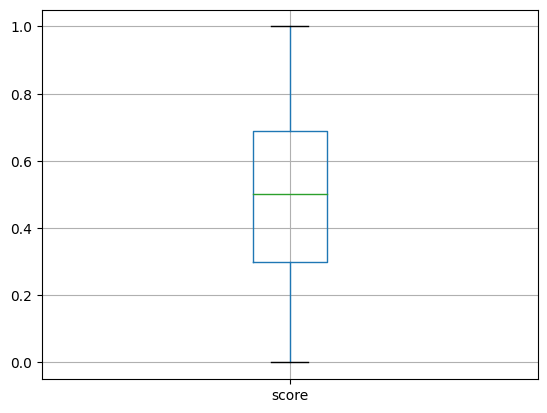

In [23]:
import matplotlib.pyplot as plt
# apply outlier detection with IQR
# remove the outliers in new_df
# find the outliers in score column
Q1 = new_df['score'].quantile(0.25)
Q3 = new_df['score'].quantile(0.75)
IQR = Q3 - Q1
print('previous length of data: ' ,len(new_df))
print("IQR: ", IQR)
# plot the boxplot to see the outliers
new_df.boxplot(column=['score'])

# remove the outliers in score column
new_df = new_df[~((new_df['score'] < (Q1 - 1.5 * IQR)) |(new_df['score'] > (Q3 + 1.5 * IQR)))]
print('current length of data: ' ,len(new_df))
plt.show()

In [24]:
# compute 3 seperate models for each problem
# create 3 df for each problem and drop problem 2 and 3 from each df
df1 = new_df[new_df['Problem 1'] == 1].drop(['Problem 1', 'Problem 2', 'Problem 3'], axis=1)
df2 = new_df[new_df['Problem 2'] == 1].drop(['Problem 1', 'Problem 2', 'Problem 3'], axis=1)
df3 = new_df[new_df['Problem 3'] == 1].drop(['Problem 1', 'Problem 2', 'Problem 3'], axis=1)

In [25]:
# for each entery in new_df, create a list of random numbers between 1 to 20 of lenght 7. 
# add the list to the end of new_df as a new column
import random
new_df['modules'] = [random.sample(range(1, 20), 7) for i in range(len(new_df))]
new_df['modules_rank'] = [random.sample([i%6/5 for i in range(1, 20)], 7) for i in range(len(new_df))]

new_df.head()

,First answer,New answer explanation,Update answer explanation,Update confidence,Request first hint,Request another hint,Change answer,Respond to hint feedback,Streamlit interaction,Run code,...,Stop reading sub-module preview,total_actions,access to GPT,Problem 1,Problem 2,Problem 3,username,score,modules,modules_rank
0,0,0,0,21,18,36,41,20,4,0,...,0,539,1,0,0,1,a1,0.583333,"[18, 2, 16, 11, 15, 3, 13]","[0.0, 1.0, 0.6, 1.0, 0.0, 0.8, 0.0]"
1,16,11,14,16,16,26,22,22,8,1,...,0,539,1,1,0,0,a1,0.687500,"[17, 19, 18, 11, 12, 1, 15]","[1.0, 0.2, 0.0, 0.0, 0.4, 0.2, 0.6]"
2,25,8,3,23,16,19,44,13,12,0,...,0,539,1,0,1,0,a1,0.450000,"[6, 9, 18, 3, 14, 12, 4]","[0.2, 0.6, 0.0, 0.0, 0.8, 0.2, 0.0]"
3,0,0,0,0,0,0,0,0,0,0,...,0,202,1,0,0,1,a2,0.000000,"[14, 6, 10, 11, 2, 1, 7]","[0.0, 0.4, 0.0, 0.2, 0.4, 0.0, 0.8]"
4,11,11,6,11,13,26,20,12,31,2,...,0,202,1,1,0,0,a2,0.437500,"[3, 9, 8, 1, 11, 12, 14]","[0.8, 0.4, 0.8, 0.6, 0.4, 0.2, 1.0]"


In [26]:
# generate a randmon number between 0 and 10 for submodule_time
new_df['submodule_time'] = [random.uniform(0, 10) for i in range(len(new_df))]

In [27]:
# create a new df with the same field as new_df for score, username, and Problem 1, 2, 3, he modules and modules_rank, submodule_time
df_syn = new_df[['username', 'Problem 1', 'Problem 2', 'Problem 3', 'modules', 'modules_rank', 'submodule_time','score']]

In [28]:
# sort the rows, such that it is for each user, the problem are order 3, 1, 2
df_syn = df_syn.sort_values(by=['username', 'Problem 2', 'Problem 1', 'Problem 3'])
df_syn = df_syn.reset_index(drop=True)
df_syn

,username,Problem 1,Problem 2,Problem 3,modules,modules_rank,submodule_time,score
0,a1,0,0,1,"[18, 2, 16, 11, 15, 3, 13]","[0.0, 1.0, 0.6, 1.0, 0.0, 0.8, 0.0]",2.573614,0.583333
1,a1,1,0,0,"[17, 19, 18, 11, 12, 1, 15]","[1.0, 0.2, 0.0, 0.0, 0.4, 0.2, 0.6]",7.235663,0.687500
2,a1,0,1,0,"[6, 9, 18, 3, 14, 12, 4]","[0.2, 0.6, 0.0, 0.0, 0.8, 0.2, 0.0]",6.811211,0.450000
3,a10,0,0,1,"[4, 14, 2, 12, 8, 9, 3]","[1.0, 0.8, 0.6, 0.8, 1.0, 0.2, 0.2]",6.488113,0.777778
4,a10,1,0,0,"[9, 15, 12, 17, 3, 10, 1]","[1.0, 0.2, 0.6, 0.2, 0.4, 0.8, 0.6]",3.919739,0.812500
...,...,...,...,...,...,...,...,...
262,b8,1,0,0,"[8, 1, 11, 3, 6, 12, 9]","[1.0, 0.2, 0.8, 0.4, 0.0, 1.0, 0.0]",0.243191,0.812500
263,b8,0,1,0,"[4, 14, 9, 19, 18, 11, 12]","[0.8, 0.4, 0.2, 0.0, 1.0, 1.0, 0.8]",5.565001,0.400000
264,b9,0,0,1,"[13, 8, 14, 15, 2, 16, 7]","[0.2, 1.0, 0.6, 1.0, 0.8, 0.0, 0.4]",9.474724,0.111111
265,b9,1,0,0,"[8, 19, 12, 14, 11, 3, 18]","[0.8, 0.4, 0.2, 0.2, 0.0, 1.0, 0.4]",4.750183,0.500000


In [29]:
# compute the improvement in score for each problem for each user by subtracting the score of the previous problem from the score of the current problem
df_syn['improvement'] = 0
for i in range(len(df_syn)):
    if df_syn.iloc[i, 1] == 1:
        df_syn.loc[i, 'improvement'] = - df_syn.loc[i, 'score'] + df_syn.loc[i+1, 'score']
    elif df_syn.iloc[i, 2] == 1:
        df_syn.loc[i, 'improvement'] = - df_syn.loc[i, 'score'] + df_syn.loc[i-2, 'score']
df_syn

,username,Problem 1,Problem 2,Problem 3,modules,modules_rank,submodule_time,score,improvement
0,a1,0,0,1,"[18, 2, 16, 11, 15, 3, 13]","[0.0, 1.0, 0.6, 1.0, 0.0, 0.8, 0.0]",2.573614,0.583333,0.000000
1,a1,1,0,0,"[17, 19, 18, 11, 12, 1, 15]","[1.0, 0.2, 0.0, 0.0, 0.4, 0.2, 0.6]",7.235663,0.687500,-0.237500
2,a1,0,1,0,"[6, 9, 18, 3, 14, 12, 4]","[0.2, 0.6, 0.0, 0.0, 0.8, 0.2, 0.0]",6.811211,0.450000,0.133333
3,a10,0,0,1,"[4, 14, 2, 12, 8, 9, 3]","[1.0, 0.8, 0.6, 0.8, 1.0, 0.2, 0.2]",6.488113,0.777778,0.000000
4,a10,1,0,0,"[9, 15, 12, 17, 3, 10, 1]","[1.0, 0.2, 0.6, 0.2, 0.4, 0.8, 0.6]",3.919739,0.812500,-0.362500
...,...,...,...,...,...,...,...,...,...
262,b8,1,0,0,"[8, 1, 11, 3, 6, 12, 9]","[1.0, 0.2, 0.8, 0.4, 0.0, 1.0, 0.0]",0.243191,0.812500,-0.412500
263,b8,0,1,0,"[4, 14, 9, 19, 18, 11, 12]","[0.8, 0.4, 0.2, 0.0, 1.0, 1.0, 0.8]",5.565001,0.400000,0.044444
264,b9,0,0,1,"[13, 8, 14, 15, 2, 16, 7]","[0.2, 1.0, 0.6, 1.0, 0.8, 0.0, 0.4]",9.474724,0.111111,0.000000
265,b9,1,0,0,"[8, 19, 12, 14, 11, 3, 18]","[0.8, 0.4, 0.2, 0.2, 0.0, 1.0, 0.4]",4.750183,0.500000,-0.450000


In [30]:
# compute the inverse mse between the sorted values in module for problem 2 with 1 and 3 with 2
from sklearn.metrics import mean_squared_error as mse
import numpy as np
df_syn['imse'] = 0
for i in range(len(df_syn)):
    if df_syn.iloc[i, 1] == 1:
        df_syn.loc[i, 'imse'] = 1/mse(np.sort(df_syn.loc[i, 'modules']), np.sort(df_syn.loc[i+1, 'modules']))
    elif df_syn.iloc[i, 2] == 1:
        df_syn.loc[i, 'imse'] = 1/mse(np.sort(df_syn.loc[i, 'modules']), np.sort(df_syn.loc[i-2, 'modules']))
df_syn

,username,Problem 1,Problem 2,Problem 3,modules,modules_rank,submodule_time,score,improvement,imse
0,a1,0,0,1,"[18, 2, 16, 11, 15, 3, 13]","[0.0, 1.0, 0.6, 1.0, 0.0, 0.8, 0.0]",2.573614,0.583333,0.000000,0.000000
1,a1,1,0,0,"[17, 19, 18, 11, 12, 1, 15]","[1.0, 0.2, 0.0, 0.0, 0.4, 0.2, 0.6]",7.235663,0.687500,-0.237500,0.041916
2,a1,0,1,0,"[6, 9, 18, 3, 14, 12, 4]","[0.2, 0.6, 0.0, 0.0, 0.8, 0.2, 0.0]",6.811211,0.450000,0.133333,0.125000
3,a10,0,0,1,"[4, 14, 2, 12, 8, 9, 3]","[1.0, 0.8, 0.6, 0.8, 1.0, 0.2, 0.2]",6.488113,0.777778,0.000000,0.000000
4,a10,1,0,0,"[9, 15, 12, 17, 3, 10, 1]","[1.0, 0.2, 0.6, 0.2, 0.4, 0.8, 0.6]",3.919739,0.812500,-0.362500,0.304348
...,...,...,...,...,...,...,...,...,...,...
262,b8,1,0,0,"[8, 1, 11, 3, 6, 12, 9]","[1.0, 0.2, 0.8, 0.4, 0.0, 1.0, 0.0]",0.243191,0.812500,-0.412500,0.033493
263,b8,0,1,0,"[4, 14, 9, 19, 18, 11, 12]","[0.8, 0.4, 0.2, 0.0, 1.0, 1.0, 0.8]",5.565001,0.400000,0.044444,0.098592
264,b9,0,0,1,"[13, 8, 14, 15, 2, 16, 7]","[0.2, 1.0, 0.6, 1.0, 0.8, 0.0, 0.4]",9.474724,0.111111,0.000000,0.000000
265,b9,1,0,0,"[8, 19, 12, 14, 11, 3, 18]","[0.8, 0.4, 0.2, 0.2, 0.0, 1.0, 0.4]",4.750183,0.500000,-0.450000,0.104478


In [31]:
# compute the overal rank based on the module_rank
df_syn['rank'] = df_syn['modules_rank'].apply(lambda x: sum(x)/len(x))
df_syn

,username,Problem 1,Problem 2,Problem 3,modules,modules_rank,submodule_time,score,improvement,imse,rank
0,a1,0,0,1,"[18, 2, 16, 11, 15, 3, 13]","[0.0, 1.0, 0.6, 1.0, 0.0, 0.8, 0.0]",2.573614,0.583333,0.000000,0.000000,0.485714
1,a1,1,0,0,"[17, 19, 18, 11, 12, 1, 15]","[1.0, 0.2, 0.0, 0.0, 0.4, 0.2, 0.6]",7.235663,0.687500,-0.237500,0.041916,0.342857
2,a1,0,1,0,"[6, 9, 18, 3, 14, 12, 4]","[0.2, 0.6, 0.0, 0.0, 0.8, 0.2, 0.0]",6.811211,0.450000,0.133333,0.125000,0.257143
3,a10,0,0,1,"[4, 14, 2, 12, 8, 9, 3]","[1.0, 0.8, 0.6, 0.8, 1.0, 0.2, 0.2]",6.488113,0.777778,0.000000,0.000000,0.657143
4,a10,1,0,0,"[9, 15, 12, 17, 3, 10, 1]","[1.0, 0.2, 0.6, 0.2, 0.4, 0.8, 0.6]",3.919739,0.812500,-0.362500,0.304348,0.542857
...,...,...,...,...,...,...,...,...,...,...,...
262,b8,1,0,0,"[8, 1, 11, 3, 6, 12, 9]","[1.0, 0.2, 0.8, 0.4, 0.0, 1.0, 0.0]",0.243191,0.812500,-0.412500,0.033493,0.485714
263,b8,0,1,0,"[4, 14, 9, 19, 18, 11, 12]","[0.8, 0.4, 0.2, 0.0, 1.0, 1.0, 0.8]",5.565001,0.400000,0.044444,0.098592,0.600000
264,b9,0,0,1,"[13, 8, 14, 15, 2, 16, 7]","[0.2, 1.0, 0.6, 1.0, 0.8, 0.0, 0.4]",9.474724,0.111111,0.000000,0.000000,0.571429
265,b9,1,0,0,"[8, 19, 12, 14, 11, 3, 18]","[0.8, 0.4, 0.2, 0.2, 0.0, 1.0, 0.4]",4.750183,0.500000,-0.450000,0.104478,0.428571


In [32]:
# create a column for the total time spend from 60 to 150
df_syn['total_time'] = [random.uniform(60, 150) for i in range(len(df_syn))]

# generate a column called engagement rate, which is the submodul_time divided by the total_time
df_syn['engagement_rate'] = df_syn['submodule_time']/df_syn['total_time']
df_syn

,username,Problem 1,Problem 2,Problem 3,modules,modules_rank,submodule_time,score,improvement,imse,rank,total_time,engagement_rate
0,a1,0,0,1,"[18, 2, 16, 11, 15, 3, 13]","[0.0, 1.0, 0.6, 1.0, 0.0, 0.8, 0.0]",2.573614,0.583333,0.000000,0.000000,0.485714,90.382843,0.028475
1,a1,1,0,0,"[17, 19, 18, 11, 12, 1, 15]","[1.0, 0.2, 0.0, 0.0, 0.4, 0.2, 0.6]",7.235663,0.687500,-0.237500,0.041916,0.342857,75.863099,0.095378
2,a1,0,1,0,"[6, 9, 18, 3, 14, 12, 4]","[0.2, 0.6, 0.0, 0.0, 0.8, 0.2, 0.0]",6.811211,0.450000,0.133333,0.125000,0.257143,74.475780,0.091455
3,a10,0,0,1,"[4, 14, 2, 12, 8, 9, 3]","[1.0, 0.8, 0.6, 0.8, 1.0, 0.2, 0.2]",6.488113,0.777778,0.000000,0.000000,0.657143,90.179790,0.071946
4,a10,1,0,0,"[9, 15, 12, 17, 3, 10, 1]","[1.0, 0.2, 0.6, 0.2, 0.4, 0.8, 0.6]",3.919739,0.812500,-0.362500,0.304348,0.542857,90.602860,0.043263
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,b8,1,0,0,"[8, 1, 11, 3, 6, 12, 9]","[1.0, 0.2, 0.8, 0.4, 0.0, 1.0, 0.0]",0.243191,0.812500,-0.412500,0.033493,0.485714,144.884319,0.001679
263,b8,0,1,0,"[4, 14, 9, 19, 18, 11, 12]","[0.8, 0.4, 0.2, 0.0, 1.0, 1.0, 0.8]",5.565001,0.400000,0.044444,0.098592,0.600000,81.010768,0.068695
264,b9,0,0,1,"[13, 8, 14, 15, 2, 16, 7]","[0.2, 1.0, 0.6, 1.0, 0.8, 0.0, 0.4]",9.474724,0.111111,0.000000,0.000000,0.571429,109.686053,0.086380
265,b9,1,0,0,"[8, 19, 12, 14, 11, 3, 18]","[0.8, 0.4, 0.2, 0.2, 0.0, 1.0, 0.4]",4.750183,0.500000,-0.450000,0.104478,0.428571,148.618538,0.031962


In [33]:
# normalize the submodule_time
df_syn['submodule_time'] = df_syn['submodule_time']/df_syn['submodule_time'].max()
df_syn

,username,Problem 1,Problem 2,Problem 3,modules,modules_rank,submodule_time,score,improvement,imse,rank,total_time,engagement_rate
0,a1,0,0,1,"[18, 2, 16, 11, 15, 3, 13]","[0.0, 1.0, 0.6, 1.0, 0.0, 0.8, 0.0]",0.258337,0.583333,0.000000,0.000000,0.485714,90.382843,0.028475
1,a1,1,0,0,"[17, 19, 18, 11, 12, 1, 15]","[1.0, 0.2, 0.0, 0.0, 0.4, 0.2, 0.6]",0.726308,0.687500,-0.237500,0.041916,0.342857,75.863099,0.095378
2,a1,0,1,0,"[6, 9, 18, 3, 14, 12, 4]","[0.2, 0.6, 0.0, 0.0, 0.8, 0.2, 0.0]",0.683702,0.450000,0.133333,0.125000,0.257143,74.475780,0.091455
3,a10,0,0,1,"[4, 14, 2, 12, 8, 9, 3]","[1.0, 0.8, 0.6, 0.8, 1.0, 0.2, 0.2]",0.651270,0.777778,0.000000,0.000000,0.657143,90.179790,0.071946
4,a10,1,0,0,"[9, 15, 12, 17, 3, 10, 1]","[1.0, 0.2, 0.6, 0.2, 0.4, 0.8, 0.6]",0.393459,0.812500,-0.362500,0.304348,0.542857,90.602860,0.043263
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,b8,1,0,0,"[8, 1, 11, 3, 6, 12, 9]","[1.0, 0.2, 0.8, 0.4, 0.0, 1.0, 0.0]",0.024411,0.812500,-0.412500,0.033493,0.485714,144.884319,0.001679
263,b8,0,1,0,"[4, 14, 9, 19, 18, 11, 12]","[0.8, 0.4, 0.2, 0.0, 1.0, 1.0, 0.8]",0.558609,0.400000,0.044444,0.098592,0.600000,81.010768,0.068695
264,b9,0,0,1,"[13, 8, 14, 15, 2, 16, 7]","[0.2, 1.0, 0.6, 1.0, 0.8, 0.0, 0.4]",0.951063,0.111111,0.000000,0.000000,0.571429,109.686053,0.086380
265,b9,1,0,0,"[8, 19, 12, 14, 11, 3, 18]","[0.8, 0.4, 0.2, 0.2, 0.0, 1.0, 0.4]",0.476818,0.500000,-0.450000,0.104478,0.428571,148.618538,0.031962


In [34]:
# average score of three problems for each user and add it to the row of problem 1
df_syn['avg_score'] = 0
for i in range(len(df_syn)):
    if df_syn.iloc[i, 1] == 1:
        df_syn.loc[i, 'avg_score'] = (df_syn.loc[i, 'score'] + df_syn.loc[i+1, 'score'] + df_syn.loc[i-1, 'score'])/3
df_syn

,username,Problem 1,Problem 2,Problem 3,modules,modules_rank,submodule_time,score,improvement,imse,rank,total_time,engagement_rate,avg_score
0,a1,0,0,1,"[18, 2, 16, 11, 15, 3, 13]","[0.0, 1.0, 0.6, 1.0, 0.0, 0.8, 0.0]",0.258337,0.583333,0.000000,0.000000,0.485714,90.382843,0.028475,0.000000
1,a1,1,0,0,"[17, 19, 18, 11, 12, 1, 15]","[1.0, 0.2, 0.0, 0.0, 0.4, 0.2, 0.6]",0.726308,0.687500,-0.237500,0.041916,0.342857,75.863099,0.095378,0.573611
2,a1,0,1,0,"[6, 9, 18, 3, 14, 12, 4]","[0.2, 0.6, 0.0, 0.0, 0.8, 0.2, 0.0]",0.683702,0.450000,0.133333,0.125000,0.257143,74.475780,0.091455,0.000000
3,a10,0,0,1,"[4, 14, 2, 12, 8, 9, 3]","[1.0, 0.8, 0.6, 0.8, 1.0, 0.2, 0.2]",0.651270,0.777778,0.000000,0.000000,0.657143,90.179790,0.071946,0.000000
4,a10,1,0,0,"[9, 15, 12, 17, 3, 10, 1]","[1.0, 0.2, 0.6, 0.2, 0.4, 0.8, 0.6]",0.393459,0.812500,-0.362500,0.304348,0.542857,90.602860,0.043263,0.680093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,b8,1,0,0,"[8, 1, 11, 3, 6, 12, 9]","[1.0, 0.2, 0.8, 0.4, 0.0, 1.0, 0.0]",0.024411,0.812500,-0.412500,0.033493,0.485714,144.884319,0.001679,0.552315
263,b8,0,1,0,"[4, 14, 9, 19, 18, 11, 12]","[0.8, 0.4, 0.2, 0.0, 1.0, 1.0, 0.8]",0.558609,0.400000,0.044444,0.098592,0.600000,81.010768,0.068695,0.000000
264,b9,0,0,1,"[13, 8, 14, 15, 2, 16, 7]","[0.2, 1.0, 0.6, 1.0, 0.8, 0.0, 0.4]",0.951063,0.111111,0.000000,0.000000,0.571429,109.686053,0.086380,0.000000
265,b9,1,0,0,"[8, 19, 12, 14, 11, 3, 18]","[0.8, 0.4, 0.2, 0.2, 0.0, 1.0, 0.4]",0.476818,0.500000,-0.450000,0.104478,0.428571,148.618538,0.031962,0.220370


In [35]:
# generate confidence level for each user between 0 and 1
df_syn['confidence'] = [random.uniform(0, 1) for i in range(len(df_syn))]
# create confidence change for each user
df_syn['confidence_change'] = 0
for i in range(len(df_syn)):
    if df_syn.iloc[i, 1] == 1:
        df_syn.loc[i, 'confidence_change'] = - df_syn.loc[i, 'confidence'] + df_syn.loc[i+1, 'confidence']
    elif df_syn.iloc[i, 2] == 1:
        df_syn.loc[i, 'confidence_change'] = - df_syn.loc[i, 'confidence'] + df_syn.loc[i-2, 'confidence']
df_syn

,username,Problem 1,Problem 2,Problem 3,modules,modules_rank,submodule_time,score,improvement,imse,rank,total_time,engagement_rate,avg_score,confidence,confidence_change
0,a1,0,0,1,"[18, 2, 16, 11, 15, 3, 13]","[0.0, 1.0, 0.6, 1.0, 0.0, 0.8, 0.0]",0.258337,0.583333,0.000000,0.000000,0.485714,90.382843,0.028475,0.000000,0.355220,0.000000
1,a1,1,0,0,"[17, 19, 18, 11, 12, 1, 15]","[1.0, 0.2, 0.0, 0.0, 0.4, 0.2, 0.6]",0.726308,0.687500,-0.237500,0.041916,0.342857,75.863099,0.095378,0.573611,0.969859,-0.501832
2,a1,0,1,0,"[6, 9, 18, 3, 14, 12, 4]","[0.2, 0.6, 0.0, 0.0, 0.8, 0.2, 0.0]",0.683702,0.450000,0.133333,0.125000,0.257143,74.475780,0.091455,0.000000,0.468026,-0.112806
3,a10,0,0,1,"[4, 14, 2, 12, 8, 9, 3]","[1.0, 0.8, 0.6, 0.8, 1.0, 0.2, 0.2]",0.651270,0.777778,0.000000,0.000000,0.657143,90.179790,0.071946,0.000000,0.287877,0.000000
4,a10,1,0,0,"[9, 15, 12, 17, 3, 10, 1]","[1.0, 0.2, 0.6, 0.2, 0.4, 0.8, 0.6]",0.393459,0.812500,-0.362500,0.304348,0.542857,90.602860,0.043263,0.680093,0.247481,0.003661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,b8,1,0,0,"[8, 1, 11, 3, 6, 12, 9]","[1.0, 0.2, 0.8, 0.4, 0.0, 1.0, 0.0]",0.024411,0.812500,-0.412500,0.033493,0.485714,144.884319,0.001679,0.552315,0.043232,0.403732
263,b8,0,1,0,"[4, 14, 9, 19, 18, 11, 12]","[0.8, 0.4, 0.2, 0.0, 1.0, 1.0, 0.8]",0.558609,0.400000,0.044444,0.098592,0.600000,81.010768,0.068695,0.000000,0.446963,0.427623
264,b9,0,0,1,"[13, 8, 14, 15, 2, 16, 7]","[0.2, 1.0, 0.6, 1.0, 0.8, 0.0, 0.4]",0.951063,0.111111,0.000000,0.000000,0.571429,109.686053,0.086380,0.000000,0.467914,0.000000
265,b9,1,0,0,"[8, 19, 12, 14, 11, 3, 18]","[0.8, 0.4, 0.2, 0.2, 0.0, 1.0, 0.4]",0.476818,0.500000,-0.450000,0.104478,0.428571,148.618538,0.031962,0.220370,0.174617,-0.031562


In [36]:
# remove the rows that improvement is zero
df_syn1 = df_syn[df_syn['improvement'] != 0]
# drop the first 6 columns
df_syn1 = df_syn1.drop(['Problem 1', 'Problem 2', 'Problem 3', 'modules', 'modules_rank', 'username', 'score'], axis=1)
# compute the correlation of features with the improvement
correlation = df_syn1.corr()['improvement']
correlation = correlation.sort_values(ascending=True)
correlation


avg_score           -0.375957
confidence_change   -0.133386
total_time          -0.089873
imse                -0.066851
submodule_time       0.076719
confidence           0.086575
rank                 0.095340
engagement_rate      0.103132
improvement          1.000000
Name: improvement, dtype: float64

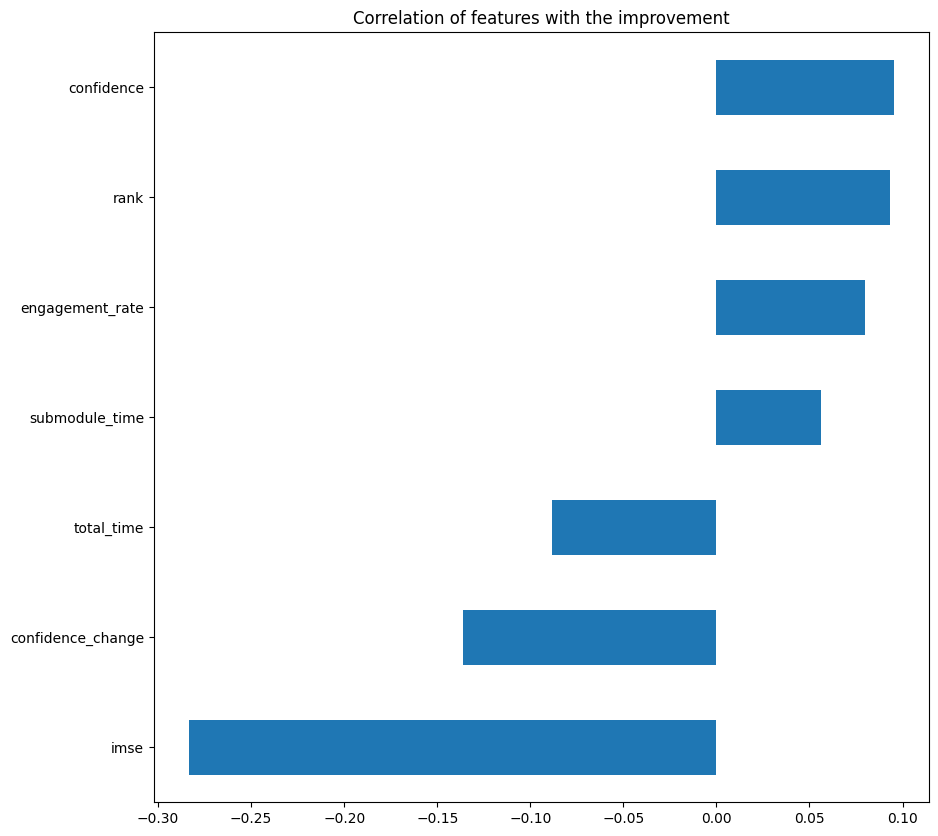

In [43]:
# plot the correlation values except the improvement
plt.figure(figsize=(10, 10))   
correlation.drop('improvement').plot(kind='barh')
plt.title('Correlation of features with the improvement')
plt.show()


In [44]:
# compute the averge for three problems
df_syn['avg_score'] = 0
for i in range(len(df_syn)):
    if df_syn.iloc[i, 1] == 1:
        df_syn.loc[i, 'avg_score'] = (df_syn.loc[i, 'score'] + df_syn.loc[i+1, 'score'] + df_syn.loc[i-1, 'score'])/3

In [46]:
# consider the avg_score as bias, find the correlation of the features with the improvement
df_syn1 = df_syn.drop(['Problem 1', 'Problem 2', 'Problem 3', 'modules', 'modules_rank', 'username', 'score'], axis=1)
# subtract the avg_score from the improvement
df_syn1['improvement'] = df_syn1['improvement'] - df_syn1['avg_score']
df_syn1 = df_syn1.drop(['avg_score'], axis=1)
correlation = df_syn1.corr()['improvement']
correlation = correlation.sort_values(ascending=True)
correlation

imse                -0.283318
confidence_change   -0.135886
total_time          -0.088316
submodule_time       0.056107
engagement_rate      0.079926
rank                 0.093062
confidence           0.095195
improvement          1.000000
Name: improvement, dtype: float64

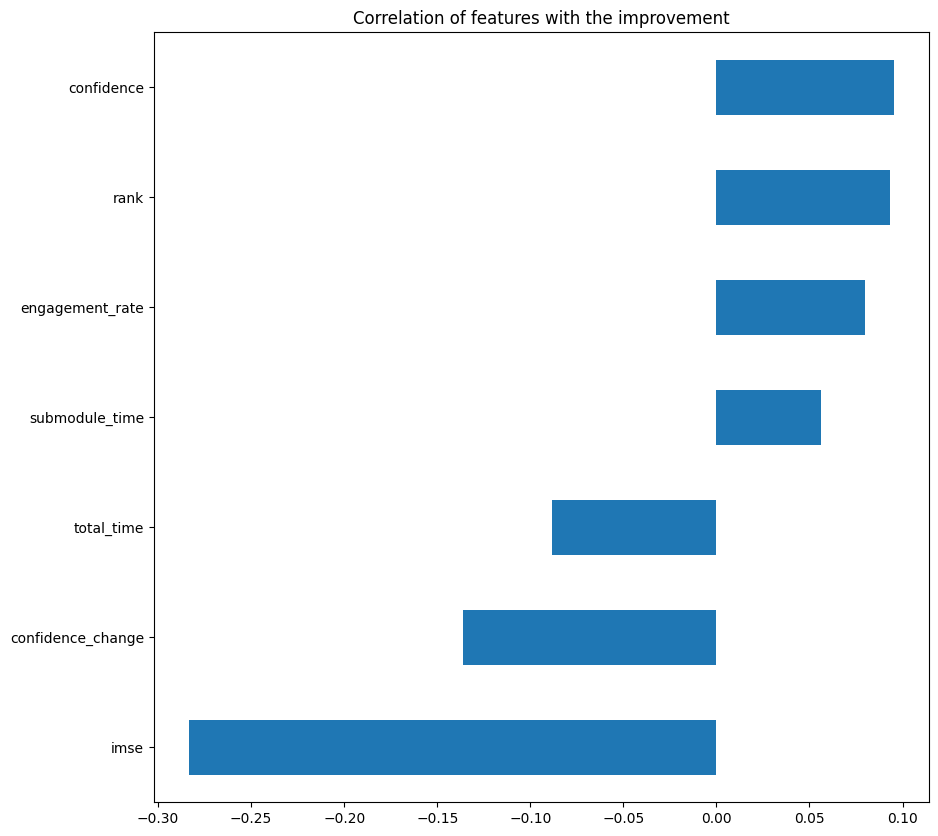

In [48]:
plt.figure(figsize=(10, 10))   
correlation.drop('improvement').plot(kind='barh')
plt.title('Correlation of features with the improvement')
plt.show()

mse:  0.14260989284462106
r2:  0.06115828928705891


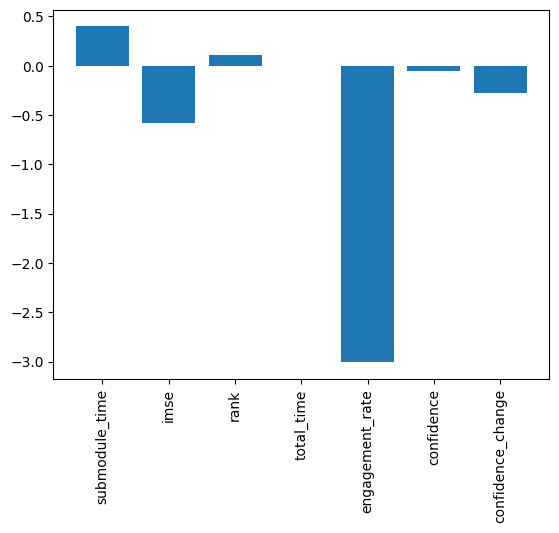

In [49]:
# train a model to predict the improvement in df_syn1
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

# split the data into train and test
X = df_syn1.drop('improvement', axis=1)
y = df_syn1['improvement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# train model
model = LinearRegression()
model.fit(X_train, y_train)

# predict the improvement
y_pred = model.predict(X_test)

# compute the mse
mse = mean_squared_error(y_test, y_pred)
print('mse: ', mse)

# compute the r2 score
r2 = r2_score(y_test, y_pred)
print('r2: ', r2)

# plot the weights of the features
weights = model.coef_
plt.bar(X.columns, weights)
plt.xticks(rotation=90)
plt.show()



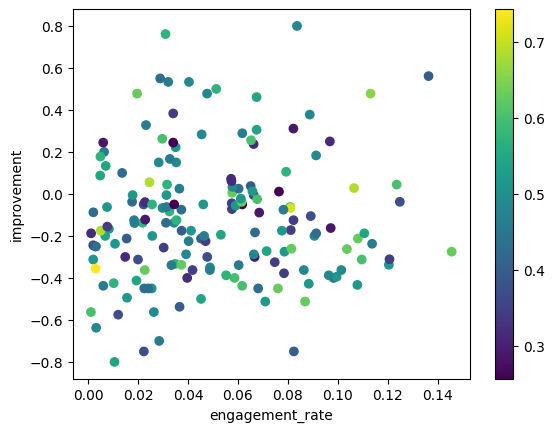

In [51]:
# create scatter plot for the improvement vs engagement_rate with the colour correspond to the imse
plt.scatter(df_syn1['engagement_rate'], df_syn1['improvement'], c=df_syn1['rank'])
plt.xlabel('engagement_rate')
plt.ylabel('improvement')
plt.colorbar()
plt.show()


In [47]:
# drop the first 6 columns
df_syn2 = df_syn.drop(['Problem 1', 'Problem 2', 'Problem 3', 'modules', 'modules_rank', 'username', 'improvement'], axis=1)
# compute the correlation of features with the score
correlation = df_syn2.corr()['score']
correlation = correlation.sort_values(ascending=True)
correlation

total_time          -0.095755
submodule_time      -0.072796
confidence_change   -0.047761
confidence          -0.025922
engagement_rate     -0.016229
rank                 0.028303
imse                 0.140621
avg_score            0.504908
score                1.000000
Name: score, dtype: float64

mse:  0.05618365357794004
r2:  0.24275715826130506


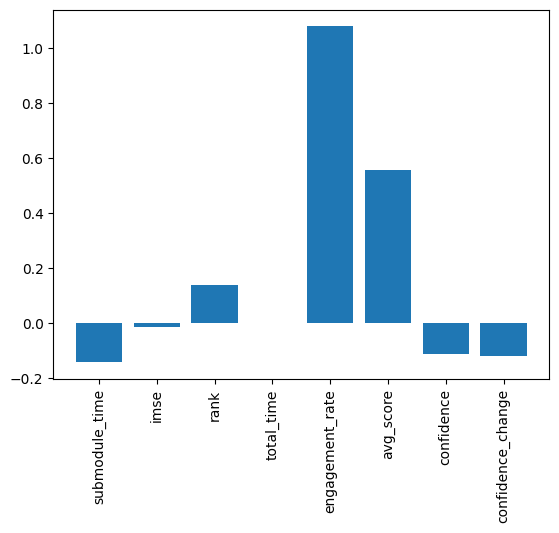

In [48]:
# split the data into train and test
X = df_syn2.drop('score', axis=1)
y = df_syn2['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# train model
model = LinearRegression()
model.fit(X_train, y_train)

# predict the improvement
y_pred = model.predict(X_test)

# compute the mse
mse = mean_squared_error(y_test, y_pred)
print('mse: ', mse)

# compute the r2 score
r2 = r2_score(y_test, y_pred)
print('r2: ', r2)

# plot the weights of the features
weights = model.coef_
plt.bar(X.columns, weights)
plt.xticks(rotation=90)
plt.show()

# implement A/B testing